In [341]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import time
import os

%matplotlib inline

In [342]:
btc = pd.read_csv("data/btc.csv")
btc.sort_values(by='Date', inplace=True)
btc = btc.reset_index()
btc.drop(btc.columns[[0,1,3,8]], axis=1, inplace=True)
btc

,Date,Open,High,Low,Close,Volume USD
0,2015-01-12 00:00:00,270.40,272.43,263.54,268.16,7.909250e+03
1,2015-01-13 00:00:00,268.16,268.72,216.00,221.00,5.765390e+04
2,2015-01-14 00:00:00,221.00,230.89,152.40,162.00,1.235998e+05
3,2015-01-15 00:00:00,162.00,233.90,161.10,208.81,8.615817e+04
4,2015-01-16 00:00:00,214.77,223.15,198.04,206.60,3.465709e+04
...,...,...,...,...,...,...
2581,2022-02-05 00:00:00,41608.82,41983.12,40975.00,41427.72,7.839110e+07
2582,2022-02-06 00:00:00,41422.70,42701.86,41141.81,42420.24,3.625555e+07
2583,2022-02-07 00:00:00,42420.24,44524.18,41682.11,43869.04,1.141240e+08
2584,2022-02-08 00:00:00,43895.60,45501.00,42701.19,44091.56,1.142766e+08


In [343]:
dataframe = btc.copy()
dataframe['Ma'] = dataframe.iloc[:,4].rolling(5).mean().shift(1)
dataframe.dropna(how='any', axis=0, inplace=True)
dataframe.replace(0, np.nan, inplace=True)
dataframe.fillna(method='bfill', inplace=True)
dataframe.iloc[:,1:] = dataframe.iloc[:,1:].apply(np.log)

In [344]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
    def __init__(self, data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, batch_size=128, shuffle=False, reverse=False, gan=False):
        self.gan = gan
        super().__init__(data, targets, length,
                                sampling_rate,
                                stride,
                                start_index,
                                end_index,
                                shuffle,
                                reverse,
                                batch_size)

    def __getitem__(self, index):
        samples, targets  = super().__getitem__(index)
        # shape : (n_batch, n_sequence, n_features)
        mean = samples.mean(axis=1)
        std = samples.std(axis=1)
        samples = (samples - mean[:,None,:])/std[:,None,:] #standarize along each feature
        if self.gan == False:
            targets = (targets - mean[:,3:4])/std[:,3:4] # The close value is our target
        else:
            targets = (targets - mean)/std # The close value is our target
        return samples, targets

In [345]:
n_sequence = 5
n_batch = 128
n_features = 6

def train_test(dataframe, is_gan=False):
  data = dataframe.drop(columns='Date').to_numpy()
  if is_gan == False:
    targets = data[:, 3, None] #add none to have same number of dimensions as data
  else:
    targets = data
  n_samples = data.shape[0]
 
  train_split = int(n_samples * 0.9)
  val_split = int(n_samples * 0.95)

  train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_split,
                                shuffle = True, 
                                gan=is_gan)

  val = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_split,
                                end_index = val_split,
                                gan=is_gan)
  
  test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = val_split,
                                end_index = n_samples-1,
                                gan=is_gan)
  
  return train, val, test

train, val, test = train_test(dataframe)
gan_train, gan_val, gan_test = train_test(dataframe, is_gan=True)

In [361]:
# keep a record of means and stds that have been used on data so we can transform later
targets = dataframe[['Close']]
targets['mean'] = targets['Close'].rolling(5).mean().shift(1)
targets['std'] = targets['Close'].rolling(5).std(ddof=0).shift(1)
targets['scaled'] = (targets['Close'] - targets['mean'])/targets['std']
test_len = 125
targets_test = targets[-test_len:]
y_actual = targets_test['Close']

/var/folders/2f/rkv3v49j0b7_2hx0f3fxytf09v2bcg/T/ipykernel_2436/1813234593.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets['mean'] = targets['Close'].rolling(5).mean().shift(1)
/var/folders/2f/rkv3v49j0b7_2hx0f3fxytf09v2bcg/T/ipykernel_2436/1813234593.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets['std'] = targets['Close'].rolling(5).std(ddof=0).shift(1)
/var/folders/2f/rkv3v49j0b7_2hx0f3fxytf09v2bcg/T/ipykernel_2436/1813234593.py:5: SettingWithCopyWarning: 
A value is trying to be 

In [362]:
def mse(y_true, y_pred):
      return tf.reduce_mean(tf.square(y_true-y_pred))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true-y_pred)))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true-y_pred)/y_true))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:] > y_true[:-1],tf.float32)
    return tf.reduce_mean((y_true[1:]-y_true[:-1])*mask)

## Baseline


In [363]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [364]:
def make_baseline():
    model = Baseline(label_index=3)
    model.compile(loss='mse', metrics = [mae, mape, rmse, ar])
    return model

baseline = make_baseline()

In [365]:
btc_results = pd.DataFrame(index=['baseline', 'linear', 'ann', 'lstm', 'gan'], columns=['mae','mape','rmse','ar'])
btc_results.loc['baseline'] = baseline.evaluate(test)[1:]

1/1 [==============================] - 1s 1s/step - loss: 10.0019 - mae: 2.0148 - mape: 6.1474 - rmse: 3.1626 - ar: 0.3945


## Linear

In [366]:
def make_linear():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=1)
        ])

    model.compile(loss='mse', metrics = [mae, mape, rmse, ar])
    return model

linear = make_linear()

In [367]:
history = linear.fit(train, validation_data=val, epochs = 100, 
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

Epoch 1/100
19/19 [==============================] - 2s 33ms/step - loss: 9.5962 - mae: 2.1500 - mape: 3.4363 - rmse: 3.0636 - ar: 0.7481 - val_loss: 5.6246 - val_mae: 1.7896 - val_mape: 1.8312 - val_rmse: 2.3716 - val_ar: 0.2494
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 9.4730 - mae: 2.0917 - mape: 3.4566 - rmse: 3.0407 - ar: 0.7194 - val_loss: 5.4923 - val_mae: 1.7652 - val_mape: 1.7750 - val_rmse: 2.3436 - val_ar: 0.2620
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 9.2782 - mae: 2.1162 - mape: 3.5785 - rmse: 3.0076 - ar: 0.8060 - val_loss: 5.3729 - val_mae: 1.7427 - val_mape: 1.7240 - val_rmse: 2.3179 - val_ar: 0.2615
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 8.8404 - mae: 2.0182 - mape: 2.3824 - rmse: 2.9480 - ar: 0.7547 - val_loss: 5.2631 - val_mae: 1.7222 - val_mape: 1.6783 - val_rmse: 2.2942 - val_ar: 0.2630
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 8.7706 - m

In [368]:
btc_results.loc['linear'] = linear.evaluate(test)[1:]

1/1 [==============================] - 0s 52ms/step - loss: 9.2755 - mae: 1.8290 - mape: 2.5675 - rmse: 3.0456 - ar: 0.4870


## ANN

In [369]:
def make_ann():
    model = keras.models.Sequential([
            keras.layers.Flatten(input_shape=(n_sequence, n_features,)),
            keras.layers.Dense(units=1000, activation=None),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(alpha=0.3),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(units=100, activation=None),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(alpha=0.3),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(1, activation=keras.layers.LeakyReLU(alpha=0.3))
        ])

    model.compile(loss='mse', metrics = [mae, mape, rmse, ar])
    model.summary()
    return model

ann = make_ann()

Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_47 (Flatten)        (None, 30)                0         
                                                                 
 dense_215 (Dense)           (None, 1000)              31000     
                                                                 
 batch_normalization_140 (Ba  (None, 1000)             4000      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_252 (LeakyReLU)  (None, 1000)             0         
                                                                 
 dropout_182 (Dropout)       (None, 1000)              0         
                                                                 
 dense_216 (Dense)           (None, 100)               100100    
                                                    

In [370]:
history = ann.fit(train, validation_data=test, epochs = 100, 
                  callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

Epoch 1/100
19/19 [==============================] - 3s 31ms/step - loss: 6.8343 - mae: 1.5787 - mape: 2.3088 - rmse: 2.5614 - ar: 1.0242 - val_loss: 8.2496 - val_mae: 1.5797 - val_mape: 1.2929 - val_rmse: 2.8722 - val_ar: 0.5001
Epoch 2/100
19/19 [==============================] - 0s 10ms/step - loss: 5.9013 - mae: 1.4646 - mape: 2.8140 - rmse: 2.4065 - ar: 1.0612 - val_loss: 8.0971 - val_mae: 1.5294 - val_mape: 3.9929 - val_rmse: 2.8455 - val_ar: 0.4421
Epoch 3/100
19/19 [==============================] - 0s 10ms/step - loss: 5.8886 - mae: 1.4653 - mape: 3.4281 - rmse: 2.3961 - ar: 1.0424 - val_loss: 8.0033 - val_mae: 1.4976 - val_mape: 1.7940 - val_rmse: 2.8290 - val_ar: 0.4893
Epoch 4/100
19/19 [==============================] - 0s 9ms/step - loss: 6.3648 - mae: 1.4300 - mape: 2.2294 - rmse: 2.4420 - ar: 1.0400 - val_loss: 8.0212 - val_mae: 1.4701 - val_mape: 2.2519 - val_rmse: 2.8322 - val_ar: 0.5499
Epoch 5/100
19/19 [==============================] - 0s 9ms/step - loss: 5.9993 -

In [371]:
btc_results.loc['ann'] = ann.evaluate(test)[1:]

1/1 [==============================] - 0s 55ms/step - loss: 7.9134 - mae: 1.4822 - mape: 2.8711 - rmse: 2.8131 - ar: 0.4588


## LSTM

In [388]:
def make_lstm():
    model = keras.models.Sequential([
    keras.layers.LSTM(units=10, input_shape=(n_sequence, n_features,), return_sequences = True, activation=None, kernel_initializer='random_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation=keras.layers.LeakyReLU(alpha=0.3))
    ])

    model.compile(loss='mse', metrics = [mae, mape, rmse, ar])
    model.summary()

    return model

lstm = make_lstm()

Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 5, 10)             680       
                                                                 
 batch_normalization_146 (Ba  (None, 5, 10)            40        
 tchNormalization)                                               
                                                                 
 leaky_re_lu_264 (LeakyReLU)  (None, 5, 10)            0         
                                                                 
 dropout_191 (Dropout)       (None, 5, 10)             0         
                                                                 
 lstm_79 (LSTM)              (None, 10)                840       
                                                                 
 batch_normalization_147 (Ba  (None, 10)               40        
 tchNormalization)                                  

In [389]:
history = lstm.fit(train, validation_data=val, epochs = 100, 
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

Epoch 1/100
19/19 [==============================] - 7s 52ms/step - loss: 6.8513 - mae: 1.6115 - mape: 1.2985 - rmse: 2.5494 - ar: 0.9197 - val_loss: 4.2408 - val_mae: 1.5611 - val_mape: 1.0002 - val_rmse: 2.0593 - val_ar: 0.3377
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 6.3632 - mae: 1.5177 - mape: 1.6568 - rmse: 2.4716 - ar: 0.9831 - val_loss: 4.2390 - val_mae: 1.5605 - val_mape: 1.0001 - val_rmse: 2.0589 - val_ar: 0.3377
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 6.3238 - mae: 1.4563 - mape: 1.8663 - rmse: 2.4656 - ar: 1.0024 - val_loss: 4.2363 - val_mae: 1.5597 - val_mape: 1.0000 - val_rmse: 2.0582 - val_ar: 0.3377
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 5.7033 - mae: 1.3878 - mape: 2.3904 - rmse: 2.3336 - ar: 0.9686 - val_loss: 4.2349 - val_mae: 1.5584 - val_mape: 0.9996 - val_rmse: 2.0579 - val_ar: 0.3377
Epoch 5/100
19/19 [==============================] - 0s 8ms/step - loss: 6.2343 - m

In [390]:
btc_results.loc['lstm'] = lstm.evaluate(test)[1:]

1/1 [==============================] - 0s 58ms/step - loss: 7.6825 - mae: 1.4585 - mape: 2.6127 - rmse: 2.7717 - ar: 0.4757


In [391]:
lstm_y_pred = lstm.predict(test).ravel()
lstm_y_pred_rescaled = np.exp((lstm_y_pred * targets_test['std']) + targets_test['mean'])

## GAN

In [376]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

In [377]:
def make_generator():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(n_sequence, n_features,)),
        keras.layers.LSTM(units=10, return_sequences = True, activation=None, kernel_initializer='random_normal'),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.3),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal'),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.3),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(n_features, activation=None),
        keras.layers.LeakyReLU(alpha=0.3)
    ])

    model.compile(loss=None, metrics = [mse , mae, mape, rmse, ar])
    model.summary()


    return model   

generator = make_generator()    

Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 5, 10)             680       
                                                                 
 batch_normalization_144 (Ba  (None, 5, 10)            40        
 tchNormalization)                                               
                                                                 
 leaky_re_lu_258 (LeakyReLU)  (None, 5, 10)            0         
                                                                 
 dropout_186 (Dropout)       (None, 5, 10)             0         
                                                                 
 lstm_77 (LSTM)              (None, 10)                840       
                                                                 
 batch_normalization_145 (Ba  (None, 10)               40        
 tchNormalization)                                  

In [378]:
def make_discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

discriminator = make_discriminator()

In [379]:
learning_rate=1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

In [380]:
EPOCHS = 2000

In [381]:
#@tf.function
def train_step_def(sequences, sequences_end):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_prediction = generator(sequences, training=True)

    sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

    real_output = discriminator(sequences_true, training=True)
    fake_output = discriminator(sequences_fake, training=True)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                            sequences_end, 
                                            fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

#@tf.function
def test_step_def(sequences, sequences_end):
  generated_prediction = generator(sequences, training=False)

  sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
  sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

  real_output = discriminator(sequences_true, training=False)
  fake_output = discriminator(sequences_fake, training=False)

  gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
  disc_loss = discriminator_loss(real_output, fake_output)
  
  return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [382]:
@tf.function
def train_step(sequences, sequences_end):
  return train_step_def(sequences, sequences_end)

@tf.function
def test_step(sequences, sequences_end):
  return test_step_def(sequences, sequences_end)

In [383]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [384]:
def train_gan(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                        tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset

        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]


        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                            tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
        


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
            .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))
        
        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    return history, history_val

In [385]:
history, history_val = train_gan(gan_train, gan_val, EPOCHS)

Time for epoch 1 is 11.888814210891724 sec Generator Loss: 0.7338381409645081,  Discriminator_loss: 1.381622076034546
Time for epoch 2 is 0.41170597076416016 sec Generator Loss: 0.7365830540657043,  Discriminator_loss: 1.3732460737228394
Time for epoch 3 is 0.3027181625366211 sec Generator Loss: 0.740634560585022,  Discriminator_loss: 1.361430287361145
Time for epoch 4 is 0.3269057273864746 sec Generator Loss: 0.7268566489219666,  Discriminator_loss: 1.356995701789856
Time for epoch 5 is 0.29945969581604004 sec Generator Loss: 0.7319896221160889,  Discriminator_loss: 1.3454989194869995
Time for epoch 6 is 0.28316402435302734 sec Generator Loss: 0.725890576839447,  Discriminator_loss: 1.3304674625396729
Time for epoch 7 is 0.2857048511505127 sec Generator Loss: 0.7189417481422424,  Discriminator_loss: 1.3139766454696655
Time for epoch 8 is 0.28012800216674805 sec Generator Loss: 0.7287835478782654,  Discriminator_loss: 1.298779010772705
Time for epoch 9 is 0.2853720188140869 sec Generat

In [386]:
btc_results.loc['gan'] = generator.evaluate(gan_test)[2:]

1/1 [==============================] - 0s 78ms/step - loss: 0.0000e+00 - mse: 3.9155 - mae: 1.0504 - mape: 1.9924 - rmse: 1.9788 - ar: 0.5767


In [392]:
btc_results

,mae,mape,rmse,ar
baseline,2.014829,6.147445,3.16257,0.39455
linear,1.828997,2.567538,3.045565,0.486973
ann,1.482231,2.871116,2.813073,0.458806
lstm,1.458477,2.61267,2.771738,0.475735
gan,1.05044,1.992394,1.978752,0.576732


In [393]:
metrics = ["gen_loss","dis_loss", ' gen_mse_loss', 'mae','mape','rmse','ar']

def plot_history(history, history_val):
  for i, metric_name in enumerate(metrics):  
    plt.figure(figsize=(12,8))
    plt.title(metric_name)
    plt.plot(history[i], label='train')
    plt.plot(history_val[i], label='val')
    plt.legend()
    plt.savefig('images/'+metric_name+'.png')
  plt.show()

TypeError: 'History' object is not subscriptable

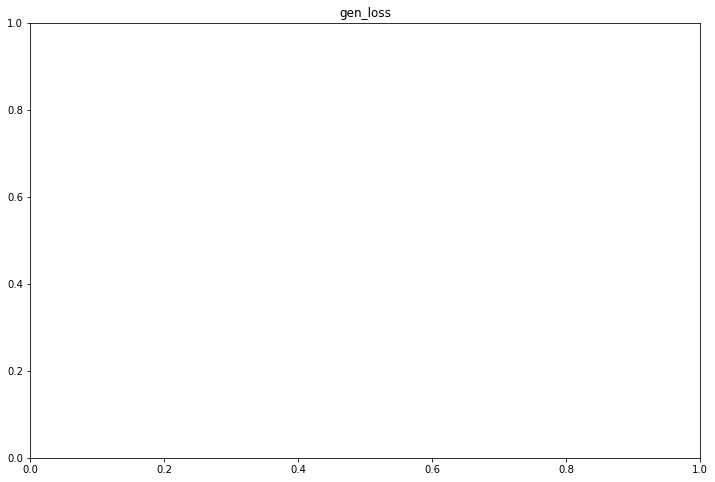

In [394]:
plot_history(history, history_val)

In [395]:
gan_y_pred = generator.predict(gan_test)[...,3]
gan_y_pred_rescaled = np.exp((gan_y_pred * targets_test['std']) + targets_test['mean'])

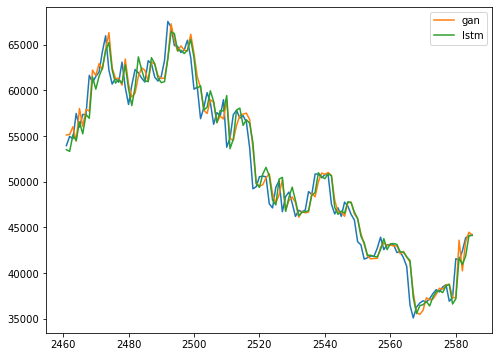

In [396]:
#y_pred = ann.predict(data_gen_test[0][0])
plt.figure(figsize=(8,6))
plt.plot(np.exp(y_actual))
plt.plot(gan_y_pred_rescaled, label='gan')
plt.plot(lstm_y_pred_rescaled, label='lstm')
plt.legend()
plt.show()

## Overall Results

In [133]:
mean_results = pd.DataFrame(index=['baseline', 'linear', 'ann', 'lstm', 'gan'], columns=['mae','mape','rmse','ar'])

In [149]:
## baseline
results = np.zeros((5,5))
names = ['btc_hourly', 'bch_hourly', 'eth_hourly', 'ltc_hourly', 'xrp_hourly']
metrics = ['loss','mae','mape','rmse','ar']

for i in range(len(names)):
    df = pd.read_csv("data/" + names[i] + ".csv")
    df.sort_values(by='Date', inplace=True)
    df = df.reset_index()
    df.drop(df.columns[[0,1,3,8]], axis=1, inplace=True)
    df = df[df.Date >= '2021-01-01']

    dataframe = df.copy()
    dataframe['Ma'] = dataframe.iloc[:,4].rolling(5).mean().shift(1)
    dataframe.dropna(how='any', axis=0, inplace=True)

    train, val, test = train_test(dataframe)

    baseline = make_baseline()
    history = baseline.fit(train, validation_data=val, epochs = 100,
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

    results[i] = baseline.evaluate(test)

mean_results.loc['baseline'] = results[:, -4:].mean(axis=0)

Epoch 1/100
277/277 [==============================] - 5s 2ms/step - loss: 3.4190 - mae: 1.4636 - mape: 18.9074 - rmse: 1.8389 - ar: 0.5013 - val_loss: 3.3816 - val_mae: 1.4315 - val_mape: 8.4756 - val_rmse: 1.8199 - val_ar: 0.0676
Epoch 2/100
277/277 [==============================] - 1s 2ms/step - loss: 3.4475 - mae: 1.4680 - mape: 3.8484 - rmse: 1.8482 - ar: 0.5172 - val_loss: 3.3816 - val_mae: 1.4315 - val_mape: 8.4756 - val_rmse: 1.8199 - val_ar: 0.0676
Epoch 3/100
277/277 [==============================] - 1s 2ms/step - loss: 3.5792 - mae: 1.4880 - mape: 14.4411 - rmse: 1.8801 - ar: 0.5274 - val_loss: 3.3816 - val_mae: 1.4315 - val_mape: 8.4756 - val_rmse: 1.8199 - val_ar: 0.0676
Epoch 4/100
277/277 [==============================] - 1s 2ms/step - loss: 3.4621 - mae: 1.4722 - mape: 6.9260 - rmse: 1.8516 - ar: 0.5249 - val_loss: 3.3816 - val_mae: 1.4315 - val_mape: 8.4756 - val_rmse: 1.8199 - val_ar: 0.0676
Epoch 5/100
277/277 [==============================] - 1s 2ms/step - loss:

In [136]:
mean_results

,mae,mape,rmse,ar
baseline,1.484215,3.575462,1.856353,0.065619
linear,NaN,NaN,NaN,NaN
ann,NaN,NaN,NaN,NaN
lstm,NaN,NaN,NaN,NaN
gan,NaN,NaN,NaN,NaN


In [150]:
## linear
results = np.zeros((5,5))
names = ['btc_hourly', 'bch_hourly', 'eth_hourly', 'ltc_hourly', 'xrp_hourly']
metrics = ['loss','mae','mape','rmse','ar']

for i in range(len(names)):
    df = pd.read_csv("data/" + names[i] + ".csv")
    df.sort_values(by='Date', inplace=True)
    df = df.reset_index()
    df.drop(df.columns[[0,1,3,8]], axis=1, inplace=True)
    df = df[df.Date >= '2021-01-01']

    dataframe = df.copy()
    dataframe['Ma'] = dataframe.iloc[:,4].rolling(5).mean().shift(1)
    dataframe.dropna(how='any', axis=0, inplace=True)

    train, val, test = train_test(dataframe)

    linear = make_linear()
    history = linear.fit(train, validation_data=val, epochs = 100,
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

    results[i] = linear.evaluate(test)

mean_results.loc['linear'] = results[:, -4:].mean(axis=0)

Epoch 1/100
277/277 [==============================] - 1s 2ms/step - loss: 4.6493 - mae: 1.7378 - mape: 22.4359 - rmse: 2.1352 - ar: 0.4345 - val_loss: 3.1192 - val_mae: 1.3824 - val_mape: 6.7426 - val_rmse: 1.7437 - val_ar: 0.0697
Epoch 2/100
277/277 [==============================] - 0s 2ms/step - loss: 2.7285 - mae: 1.3231 - mape: 8.7492 - rmse: 1.6364 - ar: 0.6052 - val_loss: 2.4804 - val_mae: 1.2418 - val_mape: 2.8439 - val_rmse: 1.5420 - val_ar: 0.0693
Epoch 3/100
277/277 [==============================] - 0s 2ms/step - loss: 2.4788 - mae: 1.2623 - mape: 1.8636 - rmse: 1.5587 - ar: 0.6022 - val_loss: 2.3950 - val_mae: 1.2203 - val_mape: 1.3462 - val_rmse: 1.5114 - val_ar: 0.0690
Epoch 4/100
277/277 [==============================] - 0s 2ms/step - loss: 2.4251 - mae: 1.2532 - mape: 1.1192 - rmse: 1.5422 - ar: 0.6213 - val_loss: 2.4010 - val_mae: 1.2201 - val_mape: 1.3915 - val_rmse: 1.5120 - val_ar: 0.0694
Epoch 5/100
277/277 [==============================] - 1s 2ms/step - loss: 

In [151]:
## ann
results = np.zeros((5,5))
names = ['btc_hourly', 'bch_hourly', 'eth_hourly', 'ltc_hourly', 'xrp_hourly']
metrics = ['loss','mae','mape','rmse','ar']

for i in range(len(names)):
    df = pd.read_csv("data/" + names[i] + ".csv")
    df.sort_values(by='Date', inplace=True)
    df = df.reset_index()
    df.drop(df.columns[[0,1,3,8]], axis=1, inplace=True)
    df = df[df.Date >= '2021-01-01']

    dataframe = df.copy()
    dataframe['Ma'] = dataframe.iloc[:,4].rolling(5).mean().shift(1)
    dataframe.dropna(how='any', axis=0, inplace=True)

    train, val, test = train_test(dataframe)

    ann = make_ann()
    history = ann.fit(train, validation_data=val, epochs = 100,
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

    results[i] = ann.evaluate(test)

mean_results.loc['ann'] = results[:, -4:].mean(axis=0)

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (None, 144)               0         
                                                                 
 dense_120 (Dense)           (None, 1000)              145000    
                                                                 
 batch_normalization_78 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 leaky_re_lu_132 (LeakyReLU)  (None, 1000)             0         
                                                                 
 dropout_93 (Dropout)        (None, 1000)              0         
                                                                 
 dense_121 (Dense)           (None, 100)               100100    
                                                     

In [152]:
## lstm
results = np.zeros((5,5))
names = ['btc_hourly', 'bch_hourly', 'eth_hourly', 'ltc_hourly', 'xrp_hourly']
metrics = ['loss','mae','mape','rmse','ar']

for i in range(len(names)):
    df = pd.read_csv("data/" + names[i] + ".csv")
    df.sort_values(by='Date', inplace=True)
    df = df.reset_index()
    df.drop(df.columns[[0,1,3,8]], axis=1, inplace=True)
    df = df[df.Date >= '2021-01-01']

    dataframe = df.copy()
    dataframe['Ma'] = dataframe.iloc[:,4].rolling(5).mean().shift(1)
    dataframe.dropna(how='any', axis=0, inplace=True)

    train, val, test = train_test(dataframe)

    lstm = make_lstm()
    history = lstm.fit(train, validation_data=val, epochs = 100,
                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

    results[i] = lstm.evaluate(test)

mean_results.loc['lstm'] = results[:, -4:].mean(axis=0)

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 24, 10)            680       
                                                                 
 batch_normalization_88 (Bat  (None, 24, 10)           40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_147 (LeakyReLU)  (None, 24, 10)           0         
                                                                 
 dropout_103 (Dropout)       (None, 24, 10)            0         
                                                                 
 lstm_35 (LSTM)              (None, 10)                840       
                                                                 
 batch_normalization_89 (Bat  (None, 10)               40        
 chNormalization)                                    

In [153]:
mean_results

,mae,mape,rmse,ar
baseline,1.484566,3.564096,1.85752,0.063898
linear,1.282559,1.180396,1.541004,0.062565
ann,0.551231,2.452348,0.802566,0.051041
lstm,0.581875,1.866058,0.827813,0.064202
gan,NaN,NaN,NaN,NaN


In [154]:
## gan
results = np.zeros((5,6))
names = ['btc_hourly', 'bch_hourly', 'eth_hourly', 'ltc_hourly', 'xrp_hourly']
metrics = ["loss", 'mse','mae','mape','rmse','ar']

for i in range(len(names)):
  df = pd.read_csv("data/" + names[i] + ".csv")
  df.sort_values(by='Date', inplace=True)
  df = df.reset_index()
  df.drop(df.columns[[0,1,3,8]], axis=1, inplace=True)
  df = df[df.Date >= '2021-01-01']

  dataframe = df.copy()
  dataframe['Ma'] = dataframe.iloc[:,4].rolling(5).mean().shift(1)
  dataframe.dropna(how='any', axis=0, inplace=True)

  gan_train, gan_val, gan_test = train_test(dataframe, is_gan=True)

  generator = make_generator()
  discriminator= make_discriminator()

  learning_rate=1e-4
  generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
  discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

  @tf.function
  def train_step(sequences, sequences_end):
    return train_step_def(sequences, sequences_end)

  @tf.function
  def test_step(sequences, sequences_end):
    return test_step_def(sequences, sequences_end)

  checkpoint_dir = './training_checkpoints/btc'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                  discriminator_optimizer=discriminator_optimizer,
                                  generator=generator,
                                  discriminator=discriminator)

  history, history_val = train_gan(gan_train, gan_val, EPOCHS)

  results[i] = generator.evaluate(gan_test)
  print(metrics,"=\n",results[i])

mean_results.loc['gan'] = results[:, -4:].mean(axis=0)

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 24, 10)            680       
                                                                 
 batch_normalization_98 (Bat  (None, 24, 10)           40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_162 (LeakyReLU)  (None, 24, 10)           0         
                                                                 
 dropout_113 (Dropout)       (None, 24, 10)            0         
                                                                 
 lstm_45 (LSTM)              (None, 10)                840       
                                                                 
 batch_normalization_99 (Bat  (None, 10)               40        
 chNormalization)                                    

In [155]:
mean_results

,mae,mape,rmse,ar
baseline,1.484566,3.564096,1.85752,0.063898
linear,1.282559,1.180396,1.541004,0.062565
ann,0.551231,2.452348,0.802566,0.051041
lstm,0.581875,1.866058,0.827813,0.064202
gan,0.596298,4.423629,0.943765,0.153789
